# VAE 3b - Interpolation med mera

1. Data load
2. Hyperparameters
3. Encoder
4. Sampling function and latent layer
5. Decoder
6. Loss
7. Build model
8. Train model
9. Plot loss
10. Compare x and x_z
11. Generate images z_x
12. Do t-sne on input space
13. Do t-sne on latent space
14. Do t-sne on output space
15. Interpolation on input space images x
16. Interpolation in latent space xzx images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses

from sklearn.manifold import TSNE

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Hyperparameters

In [2]:
z_dim = 16
h_size = 512
img_size = 28*28*1
batchsize = 32
epochs = 50

## 2. Data load

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train = np.reshape(x_train, (x_train.shape[0], img_size))
x_test = np.reshape(x_test, (x_test.shape[0], img_size))
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (60000, 784)
x_test shape: (10000, 784)


## 3. Encoder

In [4]:
enc_inputs = Input(shape=(img_size,))
enc_h1 = Dense(h_size, activation='relu')(enc_inputs)
enc_h2 = Dense(h_size / 2, activation='relu')(enc_h1)
enc_h3 = Dense(h_size / 4, activation='relu')(enc_h2)
mu = Dense(z_dim)(enc_h3)
sigma = Dense(z_dim)(enc_h3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## 4. Sampling function and latent layer

In [5]:
def sampling_z(args):
    mu, sigma = args
    eps = K.random_normal(shape=(batchsize, z_dim,), mean=0., stddev=1.)
    return mu + K.exp(sigma) * eps

z = Lambda(sampling_z, output_shape=(z_dim,))([mu, sigma])
Z = Lambda(sampling_z, output_shape=(z_dim,))

## 5. Decoder

In [6]:
dec_h1 = Dense(h_size / 4, activation='relu')
dec_h2 = Dense(h_size / 2, activation='relu')
dec_h3 = Dense(h_size, activation='relu')
dec_outputs = Dense(img_size, activation='sigmoid')

vae_decoder = dec_h1(z)
vae_decoder = dec_h2(vae_decoder)
vae_decoder = dec_h3(vae_decoder)
vae_outputs = dec_outputs(vae_decoder)



## 6. Loss

In [7]:
def loss(enc_inpupts, vae_outputs):
    reconstruction_loss = losses.binary_crossentropy(enc_inpupts, vae_outputs)
    reconstruction_loss *= 784
    kl_loss = .5 * K.sum(K.square(mu) + K.exp(sigma) - sigma - 1, axis=-1)
    return K.mean(reconstruction_loss + kl_loss)

## 7. Build model

In [8]:
vae = Model(enc_inputs, vae_outputs)
vae.summary()
vae.compile(optimizer='rmsprop', loss=loss)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
______________________________________________________________________________________________

## 8. Train model

In [9]:
history = vae.fit(x_train,
                  x_train,
                  shuffle=True,
                  epochs=epochs,
                  batch_size=batchsize,
                  verbose=1
                 )

Train on 60000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 90us/sample - loss: 270.0353
Epoch 2/50
60000/60000 [==============================] - 5s 82us/sample - loss: 245.8632
Epoch 3/50
60000/60000 [==============================] - 5s 78us/sample - loss: 240.4392
Epoch 4/50
60000/60000 [==============================] - 5s 76us/sample - loss: 237.8979
Epoch 5/50
60000/60000 [==============================] - 5s 77us/sample - loss: 236.5081
Epoch 6/50
60000/60000 [==============================] - 4s 74us/sample - loss: 235.6769
Epoch 7/50
60000/60000 [==============================] - 5s 82us/sample - loss: 235.1309
Epoch 8/50
60000/60000 [==============================] - 5s 76us/sample - loss: 234.7082
Epoch 9/50
60000/60000 [==============================] - 4s 74us/sample - loss: 234.3810
Epoch 10/50
60000/60000 [==============================] - 5s 81us/sample - loss: 234.1573
Epoch 11/50
60000/60000 [==============================] - 5s 77us/sample - 

## 9. Plot loss

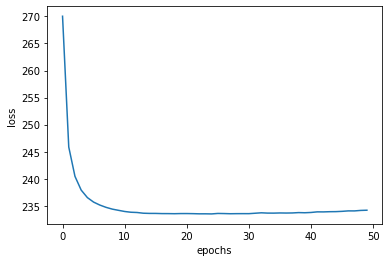

In [10]:
# Plot loss
loss = history.history['loss']
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## 10. Compare x and x_z

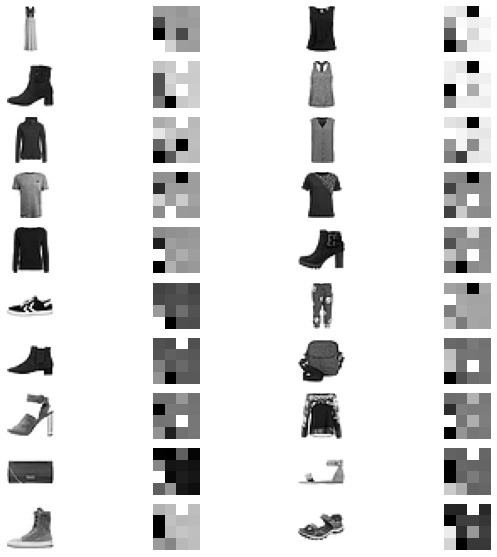

In [11]:
# Build the encoder moel
encoder_model = Model(enc_inputs, mu)
# Forwardpropagate x to z
chance = np.random.randint(len(x_test - batchsize))
x = x_test[chance: chance + batchsize]
x_z = encoder_model.predict(x)
x = x[:20]
x_z = x_z[:20]
x = np.reshape(x, (x.shape[0], 28, 28))
x_z = np.reshape(x_z, (x_z.shape[0], 4, 4))
# Plot images
fig = plt.figure(figsize=(10, 10))
counter = 1
for i, j in zip(x, x_z):
    plt.subplot(10, 4, counter)
    plt.axis('off')
    plt.imshow(i[:, :], cmap='gray_r')
    counter += 1
    plt.subplot(10, 4, counter)
    plt.axis('off')
    plt.imshow(j[:, :], cmap='gray_r')
    counter += 1
plt.show()

## 11. Generate images z_x 

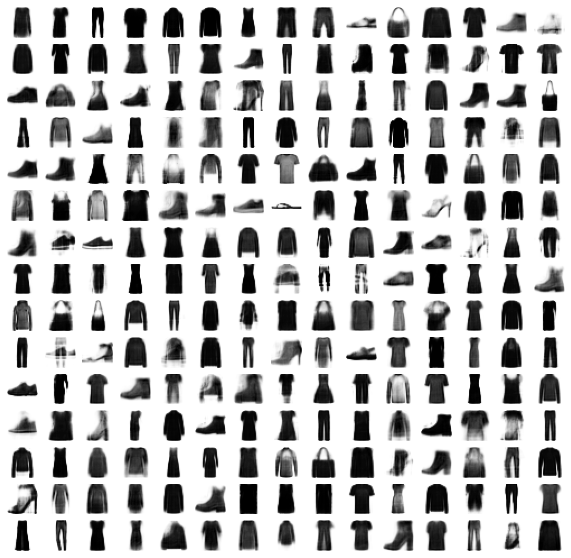

In [12]:
# Build the decoder model
dec_inputs = Input(shape=(z_dim,))
decoder = dec_h1(dec_inputs)
decoder = dec_h2(decoder)
decoder = dec_h3(decoder)
decoder_outputs = dec_outputs(decoder)
decoder_model =  Model(dec_inputs, decoder_outputs)
# Define a grid
n = 15 **2
_z = np.random.normal(loc=.5, scale=1., size=(n, z_dim))
# Display images
x_hat = decoder_model.predict(_z)
x_hat = np.reshape(x_hat, (x_hat.shape[0], 28, 28))
fig = plt.figure(figsize=(10, 10))
for i in range(n):
    img = x_hat[i]
    plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
    plt.axis('off')
    plt.imshow(img[:, :], cmap='gray_r')
plt.show()

## 12. Do t-sne on input space

In [13]:
tsne_x = TSNE(n_components=2).fit_transform(x_test)

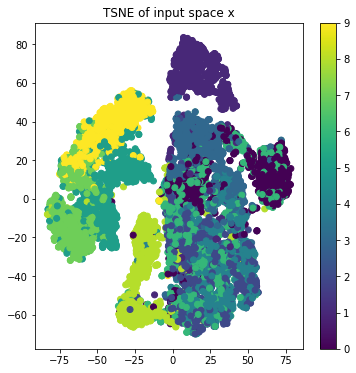

In [20]:
plt.figure(figsize=(6, 6))
plt.title('TSNE of input space x')
plt.scatter(tsne_x[:, 0], tsne_x[:, 1], c=y_test)
plt.colorbar()
plt.show()

## 13. Do t-sne on latent space

In [14]:
xz_test = encoder_model.predict(x_test)

In [15]:
tsne_xz = TSNE(n_components=2).fit_transform(xz_test)

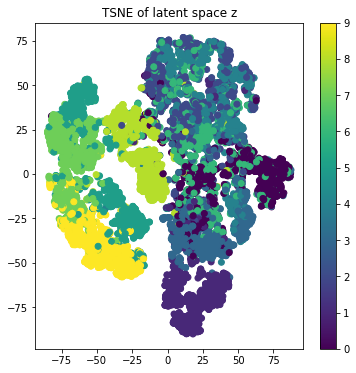

In [21]:
plt.figure(figsize=(6, 6))
plt.title('TSNE of latent space z')
plt.scatter(tsne_xz[:, 0], tsne_xz[:, 1], c=y_test)
plt.colorbar()
plt.show()

## 14. Do t-sne on output space

In [26]:
xzx_train = vae.predict(x_train)
xzx_labels = y_train[:len(x_test)]

In [27]:
tsne_xzx = TSNE(n_components=2).fit_transform(xzx_train[:len(x_test)])

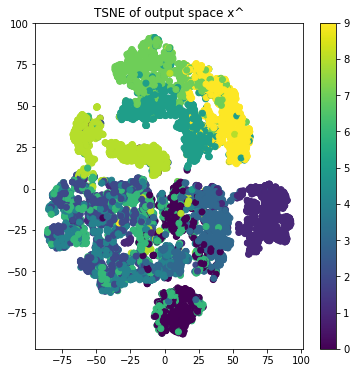

In [28]:
plt.figure(figsize=(6, 6))
plt.title('TSNE of output space x^')
plt.scatter(tsne_xzx[:, 0], tsne_xzx[:, 1], c=xzx_labels)
plt.colorbar()
plt.show()

## 15. Interpolation on input space images x

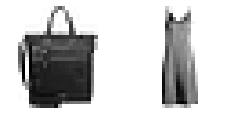

In [90]:
# Lets take two different random images from x_test and plot them
def get_two_images(x_test, y_test):
    while True:
        chance_1 = np.random.randint(len(x_test))
        xi_1 = x_test[chance_1]
        label_1 = y_test[chance_1]
        chance_2 = np.random.randint(len(x_test))
        xi_2 = x_test[chance_2]
        label_2 = y_test[chance_2]
        if label_1 is not label_2:
            return xi_1, xi_2

xi_1, xi_2 = get_two_images(x_test, y_test)
fig = plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.imshow(xi_1.reshape((28,28)), cmap='gray_r')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(xi_2.reshape((28,28)), cmap='gray_r')
plt.axis('off')
plt.show()

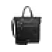

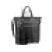

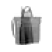

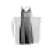

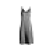

In [91]:
# Now lets get 3 new vectors with different t values and plot that with the two previous ones.
XTI = [xi_1]
T = [.2, .5, .8]
for i in range(3):
    t = T[i]
    XTI.append((xi_1 * (1 - t)) + (xi_2 * t))
XTI.append(xi_2)
for i, img in enumerate(XTI):
    fig = plt.figure(figsize=(4, 4))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.reshape((28,28)), cmap='gray_r')
    plt.axis('off')
plt.show()

## 16. Interpolation in latent space xzx images

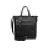

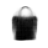

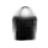

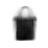

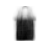

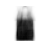

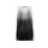

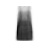

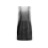

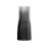

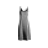

In [105]:
# 1 - pick 2 images from input space
# 2 - perform interpolation on the latent representations and obtain 3 new latent vectors
# 3 - feed the new vectors to the decoder and obtain 3 new images
# 4 - plot these 5 vectors and be amazed!!
# this time we feed it without the stochastic procedure
zi_1 = encoder_model.predict(xi_1.reshape(1, img_size))
zi_2 = encoder_model.predict(xi_2.reshape(1, img_size))
ZTI = [xi_1]
T = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
for i in range(len(T)):
    t = T[i]
    z_new = (zi_1 * (1 - t)) + (zi_2 * t)
    x_new = decoder_model.predict(z_new)
    ZTI.append(x_new)
ZTI.append(xi_2)
for i, img in enumerate(ZTI):
    fig = plt.figure(figsize=(8, 6))
    plt.subplot(1, len(ZTI), i + 1)
    plt.imshow(img.reshape((28,28)), cmap='gray_r')
    plt.axis('off')
plt.show()